In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': lambda x: format(x, '.4e')})
import time
import scipy.linalg as linalg
from matplotlib.colors import LogNorm

## Discretization

In [2]:
x1min, x1max, x1step = 0, 5, 5/31
x2min, x2max, x2step = 0, 5, 5/31
n1, n2 = int((x1max-x1min)/x1step), int((x2max-x2min)/x2step)
k = (n1-1) * (n2-1)
x1s, x2s = np.meshgrid(np.arange(x1min + x1step, x1max, x1step),
                       np.arange(x2min + x2step, x2max, x2step))
x1s, x2s = x1s.reshape(k), x2s.reshape(k) # x, y: (k,)

In [3]:
Bx = np.kron(np.eye(n2-1), 
             np.eye(n1-1,k=1)-np.eye(n1-1,k=-1)) / (2*x1step)
By = np.kron(np.eye(n2-1,k=1)-np.eye(n2-1,k=-1), 
             np.eye(n1-1)) / (2*x2step)

## Objective function

$$
f(\theta_1,\theta_2) = \frac{1}{2}\sum_{i=1}^k\big|\,\rho(\theta_1,\theta_2,x_{1i},x_{2i})-\rho^*(x_{1i},x_{2i})\,\big|^2
$$
where $\rho$ is a mixed gaussian.
$$
\rho(\theta_1,\theta_2,x_{1i},x_{2i}) =\rho_1+\rho_2= w\frac{1}{2\pi}exp\bigg(-\frac{1}{2}\big((x_{1i}-\theta_1)^2+(x_{2i}-3)^2\big)\bigg) + (1-w)\frac{1}{2\pi}exp\bigg(-\frac{1}{2}\big((x_{1i}-\theta_2)^2+(x_{2i}-2)^2\big)\bigg)
$$
Here we take $w=0.05$ such that it is ill-conditioned.

In [4]:
w = 0.02

def density(theta):
    # Discretization of rho(x, theta) with k sampling points
    # input: n (number of thetas) * 2 (dimension of theta)
    # output: rho_: n (number of thetas) * k (number of sampling points) 
    rho1s, rho2s, rhos = [], [], []
    for x1, x2 in zip(x1s, x2s):
        rho1 = w/(2*np.pi) * np.exp(-0.5*((x1-theta[0])**2+(x2-3)**2))
        rho2 = (1-w)/(2*np.pi) * np.exp(-0.5*((x1-theta[1])**2+(x2-2)**2))
        rho = rho1 + rho2

        rho1s.append(rho1)
        rho2s.append(rho2)
        rhos.append(rho)
    return np.array(rho1s), np.array(rho2s), np.array(rhos)

theta_true = [1, 3]
_, _, rho_true = density(theta_true)

def gradx_density(theta):
    # Calculate the gradient of (rho-rho*) with respect to x
    # input: n (number of thetas) * 2 (dimension of theta)
    # output: n (number of thetas) * k (number of sampling points) * 2 (dimension of theta)
    
    _, _, rho = density(theta)
    dfdrho = rho - rho_true
    d1, d2 = Bx @ dfdrho, By @ dfdrho
    return d1, d2


def L2loss(theta):
    loss = 0
    for x1, x2 in zip(x1s, x2s):
        rho1 = w/(2*np.pi) * np.exp(-0.5*((x1-theta[0])**2+(x2-3)**2))
        rho2 = (1-w)/(2*np.pi) * np.exp(-0.5*((x1-theta[1])**2+(x2-2)**2))
        rho1_true = w/(2*np.pi) * np.exp(-0.5*((x1-theta_true[0])**2+(x2-3)**2))
        rho2_true = (1-w)/(2*np.pi) * np.exp(-0.5*((x1-theta_true[1])**2+(x2-2)**2))
        loss += (rho1+rho2 - rho1_true-rho2_true)**2
    return loss/2

## 
The gradients are
$$
\partial_{\rho}f=\big[\,\rho(\theta_1,\theta_2,x_{1i},x_{2i})-\rho^*(x_{1i},x_{2i})\,\big]_{i=1}^k
$$
$$
\zeta_1 = \partial_{\theta_1}\rho = \big[\,\rho_1(x_{1i}-\theta_1)\,\big]_{i=1}^k\\
\zeta_2 = \partial_{\theta_2}\rho = \big[\,\rho_2(x_{1i}-\theta_2)\,\big]_{i=1}^k
$$

In [5]:
def std(theta):
    
    rho1, rho2, rho = density(theta)
    
    # zeta1 = d rho/d theta
    dxt1, dxt2 = [], []
    for x1, x2 in zip(x1s, x2s):
        dxt1.append(x1-theta[0])
        dxt2.append(x1-theta[1])
    zeta1 = rho1 * np.array(dxt1) 
    zeta2 = rho2 * np.array(dxt2)
    zeta = np.column_stack((zeta1, zeta2)) # k x 2
    grad = zeta.T @ (rho-rho_true)
    
    return grad

def wng(theta, ls=True):
    
    rho1, rho2, rho = density(theta)
    
    # zeta1 = d rho/d theta
    dxt1, dxt2 = [], []
    for x1, x2 in zip(x1s, x2s):
        dxt1.append(x1-theta[0])
        dxt2.append(x1-theta[1])
    zeta1 = rho1 * np.array(dxt1) 
    zeta2 = rho2 * np.array(dxt2)
    
    # solve By=z for y
    sqrt_rho = np.sqrt(rho)
    C = np.diag(sqrt_rho)
    B = -np.concatenate((np.matmul(Bx, C), np.matmul(By, C)), axis=1) # k x 2k
    Qv, Rv = linalg.qr(B.T, mode='economic') # Q: 2k x k, R: k x k
    y1 = np.matmul(Qv, linalg.solve_triangular(Rv.T, zeta1, lower=True)) # 2k
    y2 = np.matmul(Qv, linalg.solve_triangular(Rv.T, zeta2, lower=True)) # 2k
    Y = np.column_stack((y1, y2)) # 2k x 2
    
    # solve Yp=b for natural gradient
    Q, R = linalg.qr(Y, mode='economic')
    #Q, R, P = linalg.qr(Y, mode='economic', pivoting=True) # Q: 2k x 2, R: 2 x 2, P: 2
    
    if ls:
        d1, d2 = gradx_density(theta)
        b = np.concatenate((sqrt_rho * d1, sqrt_rho * d2), axis=0) # 2k
        grad = np.linalg.solve(R, Q.T @ b)
    else:
        zeta = np.column_stack((zeta1, zeta2)) # k x 2
        gradu = zeta.T @ (rho-rho_true) # 2
        Q1, R1 = linalg.qr(R.T, mode = 'economic'); # Q1: 2 x 2, R1: 2 x 2
        z = np.linalg.solve(R1, Q1.T @ gradu);
        y = np.linalg.solve(R1.T, z);
        grad = Q1 @ y;
    return grad

## Counter plot



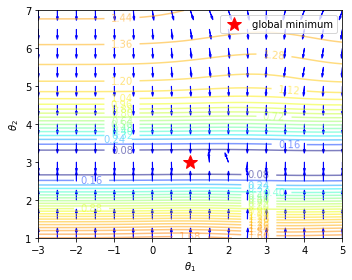

In [6]:
theta1min, theta1max, theta1step = -3, 5, .2
theta2min, theta2max, theta2step = 1, 7, .2
theta1, theta2 = np.meshgrid(np.arange(theta1min, theta1max + theta1step, theta1step),
                             np.arange(theta2min, theta2max + theta2step, theta2step))

minima = np.array(theta_true)
minima_ = minima.reshape(-1, 1)

#theta0 = np.array([6, 3.5])
#theta0_ = theta0.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(theta1, theta2, L2loss([theta1, theta2]), #levels=np.logspace(0, 0.8, 25),
                levels = np.arange(0, 4, 0.08), 
                norm=LogNorm(), alpha=0.5, cmap=plt.cm.jet)
                #levels = np.arange(0, 0.3, 0.01))
ax.clabel(CS, fontsize=10, inline=True)

tt = 0.5
for i in np.arange(theta1min, theta1max+tt, tt):
    for j in np.arange(theta2min, theta2max+tt, tt):
        grad_std = std(np.array([i, j]))
        #grad_wng = wng(np.array([i, j]), ls=True)
        #print([i,j], grad_std[1]/grad_std[0], grad_wng[0]/grad_wng[1])
        length = np.linalg.norm(grad_std)
        if (length<0.00000000001):
            ax.plot(i, j, 'r*', label = 'global minimum', markersize=15)
            continue
        direct = -grad_std/length
        plt.arrow(i, j, direct[0]/6, direct[1]/6, 
                  width=0.005, fc='blue', ec='blue', 
                  head_length = 0.1, head_width = 0.05)


#ax.plot(*minima_, 'r*', markersize=12, label='global minimum')
#ax.plot(*theta0_, 'go', markersize=8, label='initial point')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")

ax.set_xlim((theta1min, theta1max))
ax.set_ylim((theta2min, theta2max))
ax.legend(loc='upper right')
plt.tight_layout()

In [7]:
tt = 0.5
theta1min, theta1max, theta1step = -3, 5, tt
theta2min, theta2max, theta2step = 1, 7, tt

m, n = int((theta1max-theta1min)/tt), int((theta2max-theta2min)/tt)
Gw1 = np.zeros((m+1, n+1))
Gw2 = np.zeros((m+1, n+1))

for i, thetax in enumerate(np.arange(theta1min, theta1max+tt, tt)):
    for j, thetay in enumerate(np.arange(theta2min, theta2max+tt, tt)):
        grad = wng(np.array([thetax, thetay]), ls=True)
        Gw1[i][j] = grad[0]
        Gw2[i][j] = grad[1]

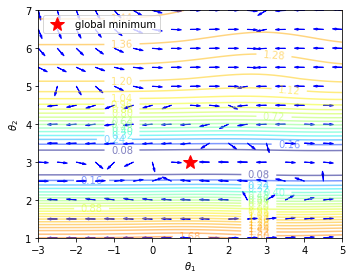

In [8]:
theta1min, theta1max, theta1step = -3, 5, .2
theta2min, theta2max, theta2step = 1, 7, .2
theta1, theta2 = np.meshgrid(np.arange(theta1min, theta1max + theta1step, theta1step),
                             np.arange(theta2min, theta2max + theta2step, theta2step))

minima = np.array(theta_true)
minima_ = minima.reshape(-1, 1)

#theta0 = np.array([6, 3.5])
#theta0_ = theta0.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(theta1, theta2, L2loss([theta1, theta2]), levels = np.arange(0, 4, 0.08), 
                norm=LogNorm(), alpha=0.5, cmap=plt.cm.jet)
                  #levels = np.arange(0, 0.3, 0.01))
ax.clabel(CS, fontsize=10, inline=True)


for i, thetax in enumerate(np.arange(theta1min, theta1max+tt, tt)):
    for j, thetay in enumerate(np.arange(theta2min, theta2max+tt, tt)):
        #grad_w = wng(np.array([i, j]), ls=False)
        grad_w = np.array([Gw1[i][j], Gw2[i][j]])
        length = np.linalg.norm(grad_w)
        if (length<0.00000000001):
            ax.plot(thetax, thetay, 'r*', label = 'global minimum', markersize=15)
            continue
        direct = -grad_w/length
        plt.arrow(thetax, thetay, direct[0]/6, direct[1]/6, 
                  width=0.005, fc='blue', ec='blue', 
                  head_length = 0.1, head_width = 0.05)

#ax.plot(*minima_, 'r*', markersize=12, label='global minimum')
#ax.plot(*theta0_, 'go', markersize=8, label='initial point')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")

ax.set_xlim((theta1min, theta1max))
ax.set_ylim((theta2min, theta2max))
ax.legend(loc='upper left')
plt.tight_layout()

## Algorithms

In [9]:
def GD(k, r, theta, func, p):
    eta = p['eta']
    grad = std(theta)
    _theta = theta - eta*grad
    return r, _theta, func(_theta), grad

In [10]:
def AEGD(k, r, theta, func, p):
    eta = p['eta']
    F = np.sqrt(func(theta)+1)
    grad = std(theta)
    v = grad / (2*F)
    _r = r / (1+2*eta*v**2)
    _theta = theta - 2*eta*_r*v
    return _r, _theta, func(_theta), grad

In [11]:
def WGD(k, r, theta, func, p):
    eta = p['eta']
    grad = wng(theta)
    _theta = theta - eta*grad
    return r, _theta, func(_theta), grad

In [12]:
def WGDE(k, r, theta, func, p):
    eta = p['eta']
    F = np.sqrt(func(theta)+1)
    grad = wng(theta)
    v = grad / (2*F)
    _r = r / (1+2*eta*v**2)
    _theta = theta - 2*eta*_r*v
    return _r, _theta, func(_theta), grad

In [13]:
def runner(theta0, func, optim, p):
    t = time.time()

    res = dict(fs=[func(theta0)], thetas=[theta0], rs=[np.sqrt(func(theta0)+1)])
    fs, thetas, rs = res['fs'], res['thetas'], res['rs']
    
    k = 1
    
    while fs[-1] > p['tol'] and k < p['maxiter']:
        r, theta, f, grad = optim(k, rs[-1], thetas[-1], func, p)
        rs.append(r)
        thetas.append(theta)
        fs.append(f)
     
        if k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, theta: {}, grad: {}'.format(k, f, theta, grad))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k-1))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(thetas[-1]))
        
    return res

In [14]:
theta0 = np.array([4, 4.2])

In [15]:
res_gd = runner(theta0, L2loss, GD, p=dict(eta=0.9, gap=10, maxiter=100, tol=1e-6))

[  10], f: 5.7767e-04, theta: [3.9811e+00 2.9763e+00], grad: [-1.1563e-04 7.2591e-06]
[  20], f: 5.7755e-04, theta: [3.9822e+00 2.9763e+00], grad: [-1.1563e-04 5.7028e-07]
[  30], f: 5.7743e-04, theta: [3.9832e+00 2.9763e+00], grad: [-1.1560e-04 5.6806e-07]
[  40], f: 5.7731e-04, theta: [3.9842e+00 2.9762e+00], grad: [-1.1557e-04 5.6585e-07]
[  50], f: 5.7719e-04, theta: [3.9853e+00 2.9762e+00], grad: [-1.1553e-04 5.6364e-07]
[  60], f: 5.7707e-04, theta: [3.9863e+00 2.9762e+00], grad: [-1.1550e-04 5.6143e-07]
[  70], f: 5.7695e-04, theta: [3.9874e+00 2.9762e+00], grad: [-1.1546e-04 5.5922e-07]
[  80], f: 5.7683e-04, theta: [3.9884e+00 2.9762e+00], grad: [-1.1543e-04 5.5701e-07]
[  90], f: 5.7671e-04, theta: [3.9894e+00 2.9762e+00], grad: [-1.1539e-04 5.5481e-07]
------------------
iterations: 99
solution time: 1.3460s
current function value: 0.0005766005986003146
current parameter value: [3.9904e+00 2.9762e+00]


In [16]:
res_aegd = runner(theta0, L2loss, AEGD, p=dict(eta=0.9, gap=10, maxiter=100, tol=1e-6))

[  10], f: 5.7801e-04, theta: [3.9782e+00 2.9763e+00], grad: [-1.1577e-04 -5.0806e-07]
[  20], f: 5.7785e-04, theta: [3.9795e+00 2.9763e+00], grad: [-1.1572e-04 7.9480e-07]
[  30], f: 5.7770e-04, theta: [3.9809e+00 2.9763e+00], grad: [-1.1567e-04 7.9078e-07]
[  40], f: 5.7754e-04, theta: [3.9823e+00 2.9763e+00], grad: [-1.1563e-04 7.8676e-07]
[  50], f: 5.7738e-04, theta: [3.9836e+00 2.9763e+00], grad: [-1.1559e-04 7.8274e-07]
[  60], f: 5.7722e-04, theta: [3.9850e+00 2.9762e+00], grad: [-1.1554e-04 7.7872e-07]
[  70], f: 5.7706e-04, theta: [3.9864e+00 2.9762e+00], grad: [-1.1550e-04 7.7471e-07]
[  80], f: 5.7690e-04, theta: [3.9877e+00 2.9762e+00], grad: [-1.1545e-04 7.7069e-07]
[  90], f: 5.7675e-04, theta: [3.9891e+00 2.9762e+00], grad: [-1.1540e-04 7.6668e-07]
------------------
iterations: 99
solution time: 2.2982s
current function value: 0.0005766031773325175
current parameter value: [3.9903e+00 2.9762e+00]


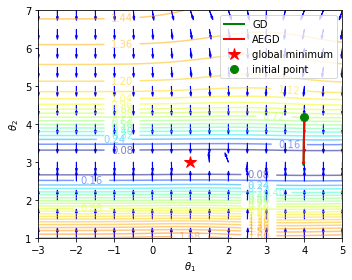

In [17]:
xg, yg = [z[0] for z in res_gd['thetas']], [z[1] for z in res_gd['thetas']]
xe, ye = [z[0] for z in res_aegd['thetas']], [z[1] for z in res_aegd['thetas']]

theta1min, theta1max, theta1step = -3, 5, .2
theta2min, theta2max, theta2step = 1, 7, .2
theta1, theta2 = np.meshgrid(np.arange(theta1min, theta1max + theta1step, theta1step),
                             np.arange(theta2min, theta2max + theta2step, theta2step))

minima = np.array(theta_true)
minima_ = minima.reshape(-1, 1)

#theta0 = np.array([4, ])
theta0_ = theta0.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(theta1, theta2, L2loss([theta1, theta2]), #levels=np.logspace(0, 0.8, 25),
                levels = np.arange(0, 4, 0.08), 
                norm=LogNorm(), alpha=0.5, cmap=plt.cm.jet)
                #levels = np.arange(0, 0.3, 0.01))
ax.clabel(CS, fontsize=10, inline=True)
ax.plot(xg, yg, color='g', linewidth=2, label='GD')
ax.plot(xe, ye, color='r', linewidth=2, label='AEGD') 

for i in np.arange(theta1min, theta1max+tt, tt):
    for j in np.arange(theta2min, theta2max+tt, tt):
        grad_std = std(np.array([i, j]))
        #grad_wng = wng(np.array([i, j]), ls=True)
        #print([i,j], grad_std[1]/grad_std[0], grad_wng[0]/grad_wng[1])
        length = np.linalg.norm(grad_std)
        if (length<0.00000000001):
            ax.plot(i, j, 'r*', label = 'global minimum', markersize=12)
            continue
        direct = -grad_std/length
        plt.arrow(i, j, direct[0]/6, direct[1]/6, 
                  width=0.005, fc='blue', ec='blue', 
                  head_length = 0.1, head_width = 0.05)


#ax.plot(*minima_, 'r*', markersize=12, label='global minimum')
ax.plot(*theta0_, 'go', markersize=8, label='initial point')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")

ax.set_xlim((theta1min, theta1max))
ax.set_ylim((theta2min, theta2max))
ax.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('aegd_mixgau_path.png', dpi=300)

In [29]:
res_wgd = runner(theta0, L2loss, WGD, p=dict(eta=0.2, gap=10, maxiter=100, tol=1e-6))

[  10], f: 7.1369e-01, theta: [3.0112e+00 4.1954e+00], grad: [2.7447e-01 6.6399e-03]
[  20], f: 6.9582e-01, theta: [2.6665e+00 4.1793e+00], grad: [1.2214e-01 8.7181e-03]
[  30], f: 6.7933e-01, theta: [2.4797e+00 4.1609e+00], grad: [7.5967e-02 9.5670e-03]
[  40], f: 6.6258e-01, theta: [2.3536e+00 4.1410e+00], grad: [5.4573e-02 1.0210e-02]
[  50], f: 6.4512e-01, theta: [2.2585e+00 4.1200e+00], grad: [4.2763e-02 1.0804e-02]
[  60], f: 6.2675e-01, theta: [2.1813e+00 4.0977e+00], grad: [3.5699e-02 1.1397e-02]
[  70], f: 6.0736e-01, theta: [2.1150e+00 4.0742e+00], grad: [3.1389e-02 1.2010e-02]
[  80], f: 5.8688e-01, theta: [2.0552e+00 4.0495e+00], grad: [2.8898e-02 1.2654e-02]
[  90], f: 5.6523e-01, theta: [1.9989e+00 4.0235e+00], grad: [2.7769e-02 1.3338e-02]
------------------
iterations: 99
solution time: 14.0821s
current function value: 0.5446869807422949
current parameter value: [1.9491e+00 3.9988e+00]


In [43]:
res_wgde = runner(theta0, L2loss, WGDE, p=dict(eta=0.48, gap=10, maxiter=100, tol=1e-6))

[  10], f: 6.9175e-01, theta: [2.6357e+00 4.1746e+00], grad: [1.2025e-01 8.7780e-03]
[  20], f: 6.5108e-01, theta: [2.3341e+00 4.1269e+00], grad: [5.3793e-02 1.0442e-02]
[  30], f: 6.0498e-01, theta: [2.1635e+00 4.0713e+00], grad: [3.5642e-02 1.1893e-02]
[  40], f: 5.5152e-01, theta: [2.0341e+00 4.0071e+00], grad: [2.9442e-02 1.3519e-02]
[  50], f: 4.8932e-01, theta: [1.9140e+00 3.9326e+00], grad: [2.9094e-02 1.5413e-02]
[  60], f: 4.1744e-01, theta: [1.7802e+00 3.8458e+00], grad: [3.4423e-02 1.7591e-02]
[  70], f: 3.3609e-01, theta: [1.5944e+00 3.7442e+00], grad: [5.2640e-02 2.0009e-02]
[  80], f: 2.4690e-01, theta: [1.1843e+00 3.6234e+00], grad: [1.5724e-01 2.3905e-02]
[  90], f: 1.2470e-01, theta: [-5.1435e-01 3.4212e+00], grad: [3.9536e-01 3.0851e-02]
------------------
iterations: 99
solution time: 14.8002s
current function value: 0.06352800452244342
current parameter value: [-1.2521e+00 3.2921e+00]


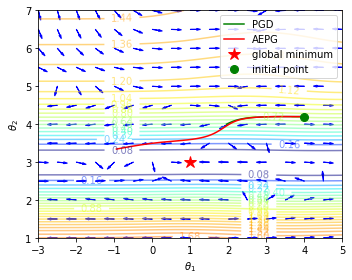

In [42]:
xg, yg = [z[0] for z in res_wgd['thetas']], [z[1] for z in res_wgd['thetas']]
xe, ye = [z[0] for z in res_wgde['thetas']], [z[1] for z in res_wgde['thetas']]

theta1min, theta1max, theta1step = -3, 5, .2
theta2min, theta2max, theta2step = 1, 7, .2
theta1, theta2 = np.meshgrid(np.arange(theta1min, theta1max + theta1step, theta1step),
                             np.arange(theta2min, theta2max + theta2step, theta2step))

minima = np.array(theta_true)
minima_ = minima.reshape(-1, 1)

#theta0 = np.array([2, 2])
theta0_ = theta0.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(theta1, theta2, L2loss([theta1, theta2]), levels = np.arange(0, 4, 0.08), 
                norm=LogNorm(), alpha=0.5, cmap=plt.cm.jet)
ax.clabel(CS, fontsize=10, inline=True)
#ax.plot(*minima_, 'r*', markersize=12, label='global minimum')

ax.plot(xg, yg, color='g', label='PGD')
ax.plot(xe, ye, color='r', label='AEPG') 


for i, thetax in enumerate(np.arange(theta1min, theta1max+tt, tt)):
    for j, thetay in enumerate(np.arange(theta2min, theta2max+tt, tt)):
        #grad_w = wng(np.array([i, j]), ls=False)
        grad_w = np.array([Gw1[i][j], Gw2[i][j]])
        length = np.linalg.norm(grad_w)
        if (length<0.00000000001):
            ax.plot(thetax, thetay, 'r*', label = 'global minimum', markersize=12)
            continue
        direct = -grad_w/length
        plt.arrow(thetax, thetay, direct[0]/6, direct[1]/6, 
                  width=0.005, fc='blue', ec='blue', 
                  head_length = 0.1, head_width = 0.05)

ax.plot(*theta0_, 'go', markersize=8, label='initial point')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")

ax.set_xlim((theta1min, theta1max))
ax.set_ylim((theta2min, theta2max))
ax.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('aeng_mixgau_path.png', dpi=300)

# 